# Setting up training with codebase

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Example dummy agent.
- this agent holds its current position/vel
- doesn't do anything.
- used to show how to setup an agent.

In [16]:
import numpy as np
from air_hockey_challenge.framework import AgentBase


def build_agent(env_info, **kwargs):
    """
    Function where an Agent that controls the environments should be returned.
    The Agent should inherit from the mushroom_rl Agent base env.

    Args:
        env_info (dict): The environment information
        kwargs (any): Additionally setting from agent_config.yml
    Returns:
         (AgentBase) An instance of the Agent
    """

    return DummyAgent(env_info, **kwargs)

'''
    We will compute the action which is desired pos & vel.
'''

class DummyAgent(AgentBase):
    def __init__(self, env_info, **kwargs):
        super().__init__(env_info, **kwargs)
        self.new_start = True
        self.hold_position = None

    def reset(self):
        self.new_start = True
        self.hold_position = None

    def draw_action(self, obs):
        # breaking down observation into something we can use
        # self.get_joint_pos(obs), self.get_joint_vel(obs), self.get_puck_pos(obs)
        
        hold_position = self.get_joint_pos(observation)
        velocity = np.zeros_like(hold_position)
        action = np.vstack([hold_position, velocity])
        return action

### Setup PyTorch Neural Network to convert observation space to action space
### Requirements
- setup Policy Gradient Method
- setup Policy
    - have a neural network (we are learning that)
    - setup TorchApproximator (connect Torch with MushroomRL)
    - plug Approximator into a Parametric Policy
- Plug Policy into Policy Gradient Method
- Train

In [17]:
#super stupid forward pass neural network
class DefenseGenerator(nn.Module):
    def __init__(self, input_dim, output_dim, use_cuda = False, dropout=False, activation = nn.LeakyReLU(0.1) ):
        super().__init__()
        
        num_layers = 20
        layer_width = 10
        
        
        layers = [nn.Linear(input_dim, layer_width), activation]
        for i in range(num_layers-1):
            layers.append(nn.Linear(layer_width, layer_width))
            layers.append(activation)
        layers.append(nn.Linear(layer_width, output_dim))
        layers.append(activation)
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, obs):
        out = self.model(obs.float())
        
        # return torch.reshape(out,6)
        return out

In [18]:
network = DefenseGenerator(8,6)
print(network(torch.zeros(1,8)).shape)

torch.Size([1, 6])


### Setup DeepDummy Agent

In [19]:
from mushroom_rl.algorithms.policy_search import REINFORCE
from mushroom_rl.policy.deterministic_policy import DeterministicPolicy
from mushroom_rl.policy.gaussian_policy import GaussianPolicy
from mushroom_rl.approximators.parametric import TorchApproximator
from mushroom_rl.utils.optimizers import AdaptiveOptimizer

/home/jyue86/anaconda3/envs/eecs298/lib/python3.8/site-packages/numpy_ml/rl_models/rl_utils.py:25: DependencyWarning: Agents in `numpy_ml.rl_models` use the OpenAI gym for training. To install the gym environments, run `pip install gym`. For more information, see https://github.com/openai/gym.
  warnings.warn(fstr, DependencyWarning)


In [ ]:
#setting this up

import numpy as np
from air_hockey_challenge.framework.air_hockey_challenge_wrapper import AirHockeyChallengeWrapper
from air_hockey_challenge.framework.challenge_core import ChallengeCore, CustomChallengeCore
from mushroom_rl.algorithms.policy_search import REINFORCE, GPOMDP, eNAC, RWR, PGPE, REPS, ConstrainedREPS, MORE
from mushroom_rl.distributions import GaussianCholeskyDistribution

search_method = "PGPE"
log_path = f"/home/jyue86/Documents/air_hockey_challenge/experiments/policy_search/{search_method}"
def custom_reward_function(base_env, state, action, next_state, absorbing):
#     print("State:")
#     print(state)
#     print("======")
#     print("Action:")
#     print(action)
#     print("======")
#     print("Next State")
#     print(next_state)
#     print("======")
    reward_value = (state[0] - state[6]) * 2 + (1/abs(state[1] - state[7])) * 2 + absorbing * 3 + \
            (next_state[0] - next_state[6]) * 4 + (1/abs(next_state[0] - next_state[6]))
    with open(log_path, "a", encoding="utf-8") as f:
        f.write(f"{reward_value}\n")
    print(reward_value)
    return reward_value

mdp = AirHockeyChallengeWrapper(env="3dof-defend", action_type="position-velocity", interpolation_order=3, custom_reward_function=custom_reward_function, debug=True)

approximator = TorchApproximator(input_shape=12,
                                 output_shape=6,
                                 network=DefenseGenerator,
                                 loss=F.smooth_l1_loss,
                                 # optimizer={'class': optim.Adam, 'params': {'lr': .001}},
                                 use_cuda=False)
policy = GaussianPolicy(approximator,torch.eye(6))
old_weights = policy.get_weights()

white_box_algorithm_params = {'mdp_info': mdp.info,
                    'policy': policy,
                    'optimizer':  AdaptiveOptimizer(eps=0.01)
                   }

mu = np.zeros(policy.weights_size)
sigma = 1e-3 * np.eye(policy.weights_size)
distribution = GaussianCholeskyDistribution(mu, sigma)
black_box_algorithm_params = {
    'mdp_info': mdp.info,
    'policy': policy,
    'optimizer':  AdaptiveOptimizer(eps=0.01),
    'distribution': distribution,
    # 'beta': 0.07
}


reinforce = PGPE(**black_box_algorithm_params)

core = CustomChallengeCore(reinforce, mdp)

core.learn(n_episodes=50, n_episodes_per_fit=10, render=False) #render allows us to visualize what's going on


  0%|                                                                                          | 0/50 [00:00<?, ?it/s]

11.4184629596825
11.188490730460824
11.028699114747027
10.78887794516871
10.542780280082647
10.415228024810629
10.268833431899523
10.195230818514506
10.112894411455782
9.940340735229542
9.752863943796124
9.624755414390053
9.480754808852186
9.22807263450832
8.885102190804755
8.590062440339265
8.38540001940742
8.29977516753528
8.202483392214395
8.272925461369086
8.384719543106211
8.477453488225217
8.410500091497838
8.730301896188235
8.640192244517442
8.387717590124536
8.125226937460544
7.567929352960894
7.262525398914461
6.963646833838936
6.990754346835786
7.350916272219177
8.387175583077031
11.380559731900576
26.44151347046888
28.210110530141012
11.16007592350864
8.042428150330347
17.501375487489707
5.033073206071771
1.678394239235403
0.0867170128970347
-0.9291664124514596
-1.446426079394133
-1.7429249344383777
-1.86051967203445
-1.8909254513004867
-1.9506953414513528
-1.98189168937366
-1.9580853766033672
-1.8103075905231731
-1.617920691389926
-1.38635902433822
-0.9550110693794085
-0.62


  2%|█▋                                                                                | 1/50 [00:03<02:58,  3.64s/it]

10.634392099973077
12.328916455052537
12.958324423225864
12.445828885544035
14.563543519761403
17.614774696396275



  4%|███▎                                                                              | 2/50 [00:06<02:37,  3.29s/it]

11.297493535120186
10.976168220437616
10.627942274444846
10.3437933365428
10.129282491450128
9.849178008473512
9.588923225389735
9.358173361424008
9.136987619490272
8.838472086870263
8.615920627881714
8.381479778483826
8.085374486575732
7.817871939077605
7.621465904029056
7.418463682661622
7.194533732386263
7.045212346149718
6.8571474107254415
6.775558989512652
6.850816829592264
7.132790893838061
7.476032738868444
8.420420641925704
10.627129074045365
13.917061461004302
27.3189354950188
31.662161741721793
15.909288713345848
10.89313309842071
10.582220105726016
10.35555079113377
10.067679101557221
9.849813697279894
9.564353723039002
9.34155389827255
9.128097087954224
8.842075820720824
8.613963748260256
8.388671023150529
8.074673121614808
7.702420177910788
7.4217998641777765
7.125044735889676
6.88860606083727
6.700917278749964
6.60375866584274
6.539892128217568
6.473572195832336
6.389866118143939
6.363284551829718
6.355521430147008
6.320746479624921
6.433424403431289
6.973848520428927
8.1


  6%|████▉                                                                             | 3/50 [00:09<02:33,  3.27s/it]

8.40756291846218
10.180704374752318
12.27395473487768
16.290751591481214
12.258809678571845
12.113938277152496
12.005530789495449
11.956733712790065
11.811981564011278
11.673915257629538
11.56361822137808
11.51520824736228
11.431397950644854
11.268581632909632
11.14780015596582
11.012380684323206
10.823802326132132
10.642873424352693
10.456174056089212
10.35638592837268
10.172397068426264
10.003314853273752
9.86559985960337
9.783540392114563
9.61307198297646
9.531845592406235
9.509528838853516
9.347819574849222
9.325154069529217
9.264200796313649
9.04469844619661
8.703411357151825
8.209292421167744
7.817345611241601
7.5599863178556195
7.422450859863828
7.463755950449749
7.917342313026449
9.405094848243479
14.278326874738578
23.420284560117125
20.439949609322287
55.678935430271785
31.010859684686547
15.81648171493715
15.429625926126082
16.066611955614317
15.328915986725198
15.476935971785316
14.552490409445056
17.39885208982965
25.276046102645562
100.60039724251972
14.55108753699718
12.

In [7]:
policy.get_weights()

In [21]:
import pickle

In [30]:
with open(f"./experiments/policy_search/{search_method}_weights.pkl", "wb") as f:
    pickle.dump(policy.get_weights(), f)

In [27]:
with open(f"./experiments/policy_search/{search_method}_weights.pkl", "rb") as f:
    weights = pickle.load(f)
    print(weights)

[-0.06414664  0.01356939  0.16463724 ...  0.06566991 -0.22713615
  0.3354656 ]


In [11]:
from matplotlib import pyplot as plt
import numpy as np

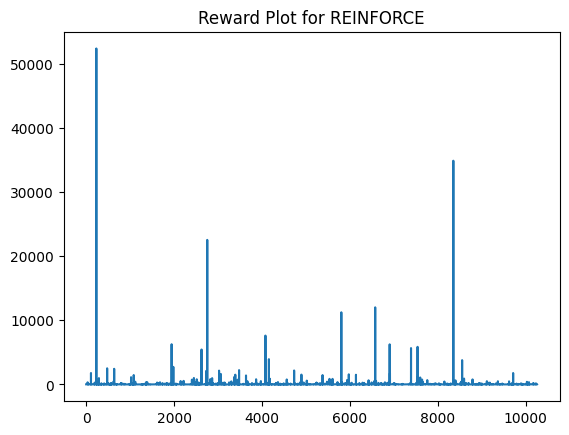

In [14]:
with open(f"./experiments/policy_search/REINFORCE", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for REINFORCE")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

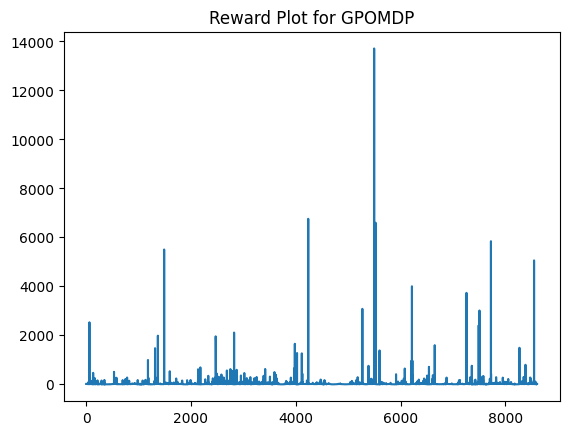

In [23]:
with open(f"./experiments/policy_search/GPOMDP", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for GPOMDP")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

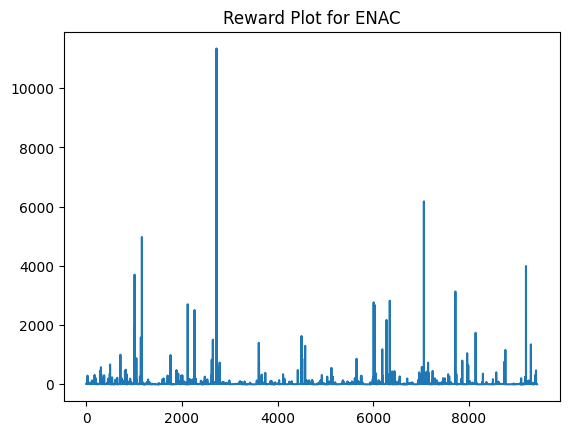

In [28]:
with open(f"./experiments/policy_search/eNAC", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for ENAC")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))

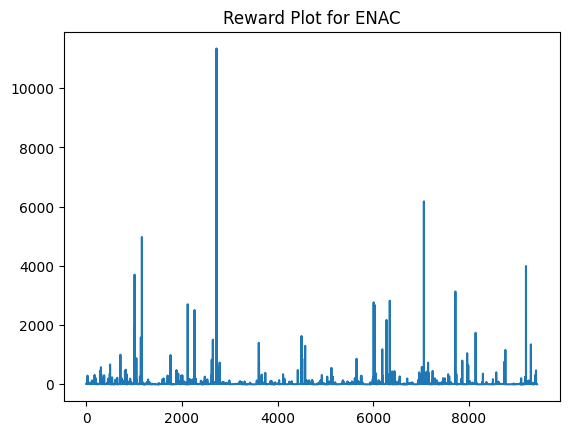

In [31]:
with open(f"./experiments/policy_search/eNAC", "r") as f:
    reward_data = []
    for line in f.readlines():
        reward_data.append(float(line[:-1]))
    plt.title("Reward Plot for ENAC")
    plt.plot(np.arange(len(reward_data)), np.array(reward_data))